In [1]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

from open_data  import matlab_file
from structure_data import  manage, struct_tools
from measures import ISI, FiringRate, tools
from classify import HistGrad

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms


import os
import sys

%load_ext autoreload
%autoreload 2

# Load and format data

### Load data

In [2]:
#Load
session, data_path, info_path = matlab_file.from_lab(lab_desktop=True, session='t150204001')
data, load_info = matlab_file.open(data_path)
session_info_raw = matlab_file.clean(info_path)


43 files loaded


In [3]:
# get sessions and units information (unit, prob, elitrials)
info_units,  info_session = manage.info(load_info, session_info_raw, session)
unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = manage.units_label(info_units)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(manage.elitrials)
# get unit's index without eli trials 
completeUnit = manage.CompleteTasktime(info_session, load_info, session)
unit_label[:5]

Complete unit found ! 
loading index = 2
matfile : t150204001_probe1_contact3_unit1.mat


['P1-23-2', 'P1-5-1', 'P1-3-1', 'P1-1-1', 'P2-6-1']

In [4]:
spike_times, task_times, target_info = matlab_file.extract_data(\
        load_info, data, target_keys_OFF=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'],\
        target_keys_ON=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], \
        event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

### Format spike times 

In [5]:
event_labels = matlab_file.get_event_labels(task_times)
event_times = matlab_file.get_event_times(task_times, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = manage.events_by_trial(event_times, event_labels)

In [6]:
unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {task_times[0][1].keys()}')


times as list : [3047992 3049069 3050391 3051713 3053021 3054320 3054799]
times as neo events : [3047992. 3049069. 3050391. 3051713. 3053021. 3054320. 3054799.] ms
spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time'])


In [7]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


### Format target

In [8]:
target = manage.target_by_trials(target_info, completeUnit)
target

,trial_type,position,type_and_pos
0,1,2,0
1,1,2,0
2,1,3,1
3,1,3,1
4,1,4,2
...,...,...,...
171,1,3,1
172,2,3,4
173,2,4,5
174,2,4,5


### Format trials

In [9]:
# align times by trials for each neurons
df_task_ts_by_neuron = manage.time_by_trials(df_task_ts_by_neuron, df_task_ts, event_labels)
df_task_ts_by_neuron[0][1]

# split the spike time vector by trial
spk_trials, spike_train_trial = manage.spike_ts_by_trial(trials_ts, spike_times)
spikes_times_aligned = manage.spike_ts_aligned(df_task_ts, df_task_ts_by_neuron, spike_times, unit_label, spike_train_trial)

/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:360: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start = data.iloc[idx_trial_valid][1]
/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stop = data.iloc[idx_trial_valid][-1]
/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:383: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

# Raster plot

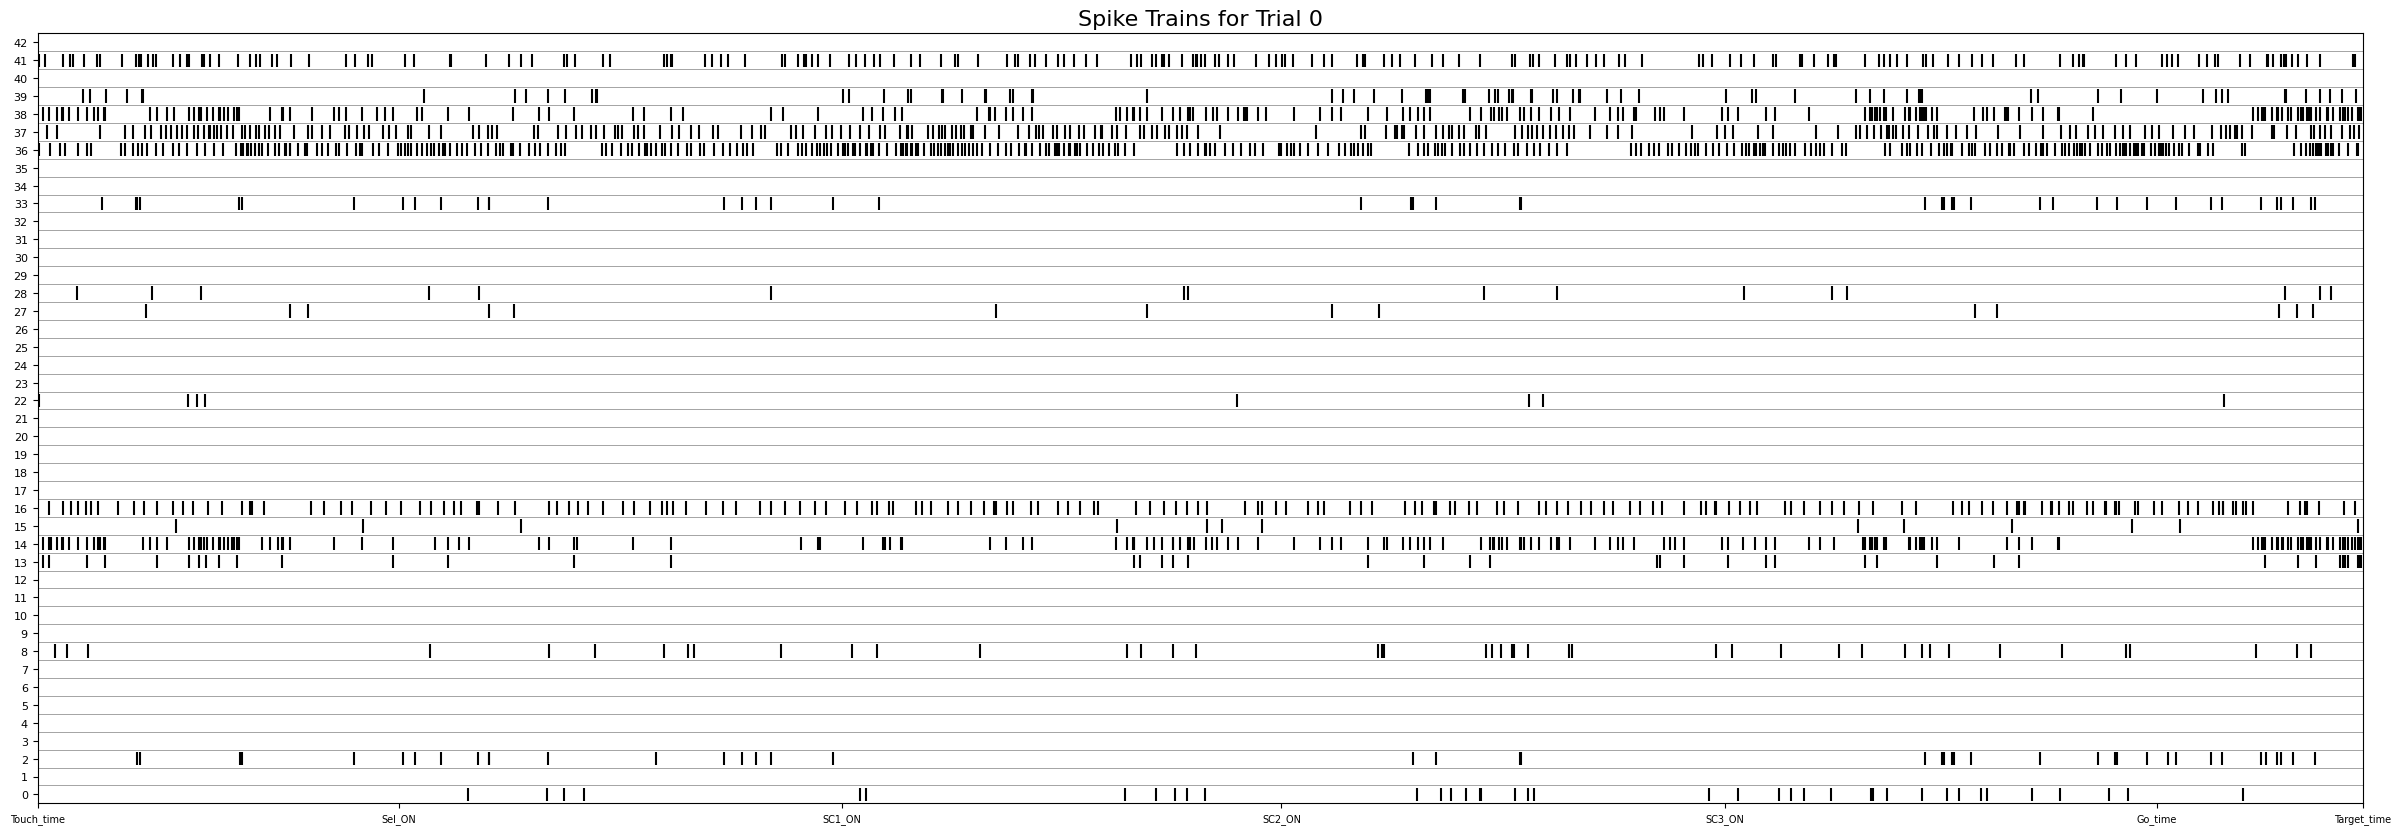

In [10]:
n_neurons = spikes_times_aligned.shape[0]
n_trials = spikes_times_aligned.shape[1]

t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(30, 10))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


In [103]:
import numpy as np

def get_spike_times_vect(spikes_times_aligned):
    n_trials = spikes_times_aligned.shape[1]
    n_neurons = spikes_times_aligned.shape[0]
    spk_times = np.zeros((n_trials, n_neurons), dtype=object)
    last_spike = np.full((n_trials, n_neurons), np.nan)

    for n in range(n_neurons):
        for t in range(n_trials):
            if (spikes_times_aligned[n][t]['spike_time'].size > 0) and (spikes_times_aligned[n][t]['spike_time'][0] != 0):
                spk_times[t, n] = spikes_times_aligned[n][t]['spike_time']
                last_spike[t, n] = spikes_times_aligned[n][t]['spike_time'].max()
            else:
                # Handle the case when the array is empty
                spk_times[t, n] = np.full(1, -1)
                last_spike[t, n] = np.array(-1)  # Or any other value you deem appropriate

    # Concatenate while preserving NaN values
    concatenated_spk_times = []
    for spk_time in spk_times.flatten():
        if isinstance(spk_time, np.ndarray):
            concatenated_spk_times.extend(spk_time)
        else:
            concatenated_spk_times.append(np.array(np.nan))

    return np.array(concatenated_spk_times), last_spike, spk_times


In [104]:
spike_times_vec, last_spikes, spk_ts = get_spike_times_vect(spikes_times_aligned)

In [105]:
epochs = struct_tools.create_epochs(spikes_times_aligned)
channels = np.arange(0, n_neurons)

In [106]:
# Initialize ii_spike_times array
ii_spike_times = np.zeros((len(epochs), len(channels), 2), dtype=int)

start_idx = 0
for epoch_idx, epoch in enumerate(epochs):
    for channel_idx, channel in enumerate(channels):
        ii_spike_times[epoch_idx, channel_idx, 0] = start_idx
        stop_idx = start_idx + spk_ts[epoch_idx,channel_idx].shape[0]
        ii_spike_times[epoch_idx, channel_idx, 1] = stop_idx
        start_idx = stop_idx

In [116]:
print ("ii_spike_times.shape", ii_spike_times.shape)
print ("# epochs =", ii_spike_times.shape[0])
print ("# neurons =",ii_spike_times.shape[1])

ii_spike_times.shape (176, 43, 2)
# epochs = 176
# neurons = 43


# SpikeShip Demo

In [108]:
from spikeship import spikeship, tools

In [109]:
%%time
spike_times = spike_times_vec
epoch_labels = target_info[completeUnit][1]['Trial_type']
spikeship_diss = spikeship.distances(spike_times, ii_spike_times)

CPU times: user 6.65 s, sys: 25.9 ms, total: 6.68 s
Wall time: 4.06 s


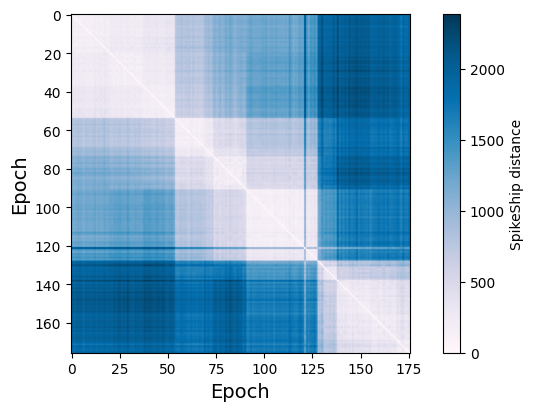

In [115]:
alpha = 0.5; marker = 'o';

# true labels sorting
#si = np.argsort(epoch_labels)

plt.figure(figsize=(5.5,4), facecolor='w', constrained_layout=True)

# dissimilarity matrices (vis)
im0 = plt.imshow(spikeship_diss[:][:], cmap='PuBu')
plt.colorbar(label="SpikeShip distance")
plt.xlabel("Epoch", fontsize=14); plt.ylabel("Epoch", fontsize=14); 